In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [3]:
PROTEIN='KRAS'
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09'
results_prefix=DATA+'/'+PROTEIN+'/processed_data/A549.'+PROTEIN
FIGS=DATA+'/Figures'
os.system('mkdir -p '+FIGS)

0

In [19]:
adata=sc.read(results_prefix+'.raw.h5ad')
adata

Only considering the two last: ['.raw', '.h5ad'].
Only considering the two last: ['.raw', '.h5ad'].


AnnData object with n_obs × n_vars = 192000 × 33694 
    obs: 'batch'

In [20]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 14754 cells that have less than 200 genes expressed
filtered out 9212 genes that are detected in less than 3 cells


normalizing counts per cell
    finished (0:00:11)


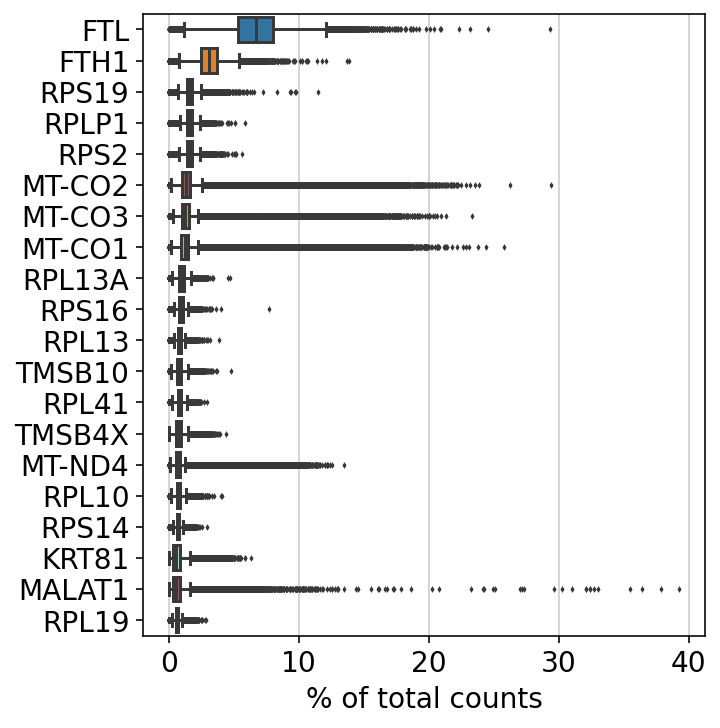

In [21]:
sc.pl.highest_expr_genes(adata, n_top=20, )

In [22]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

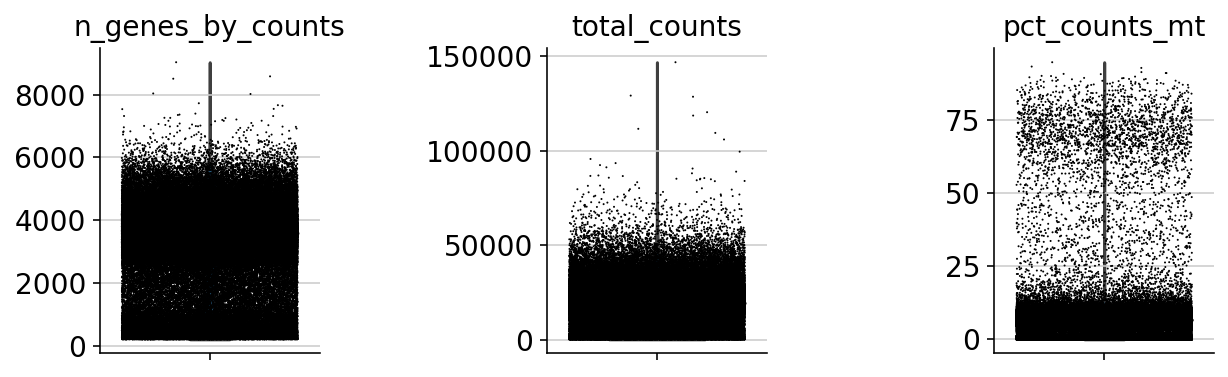

In [23]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

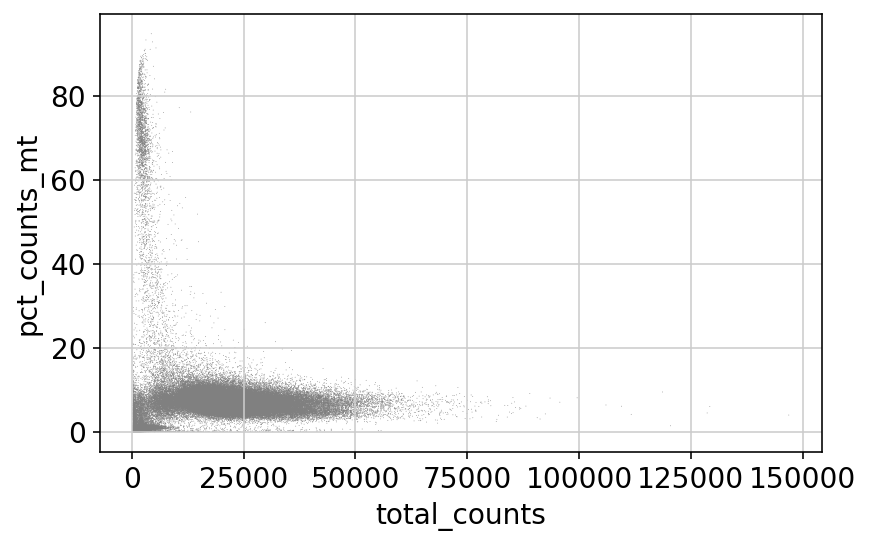

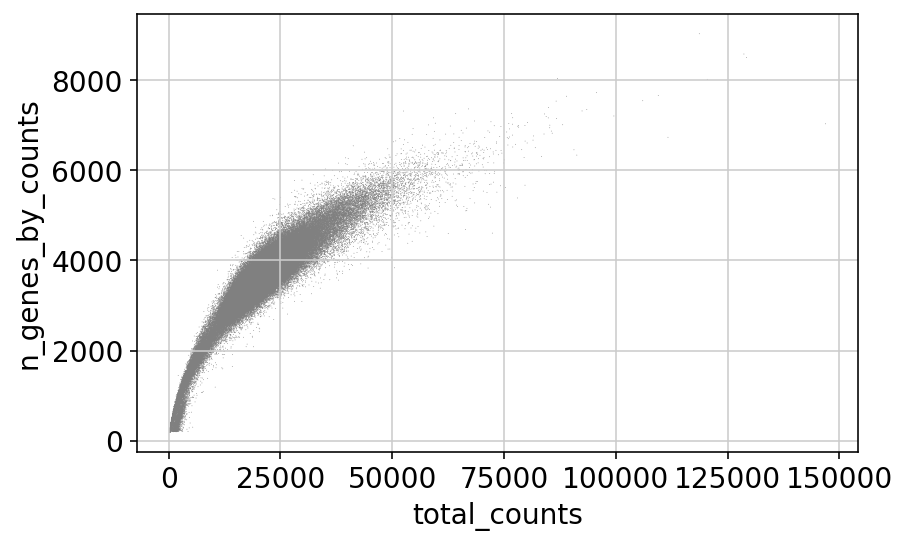

In [24]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [25]:
adatas={PROTEIN:adata}

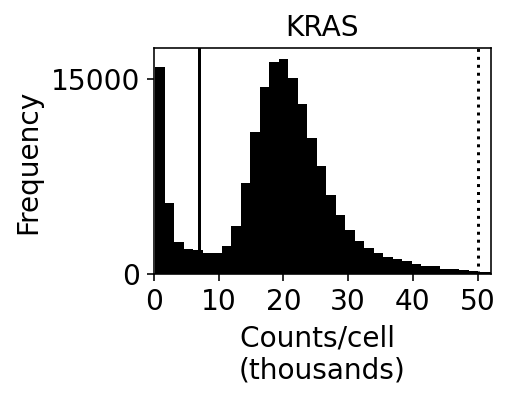

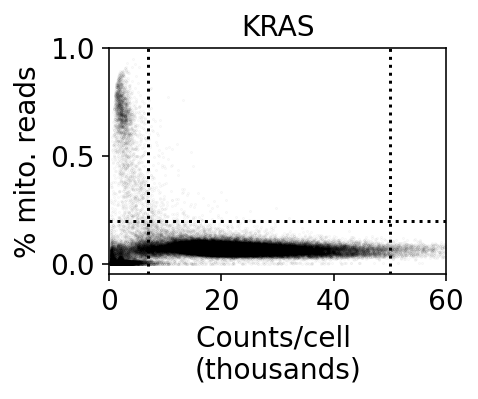

In [26]:
fw=3
fh=2

for protein in adatas:
    
    my_adata=adatas[protein]
    
    fig, plots = plt.subplots(1,1)
    fig.set_size_inches(fw,fh)
    plots.hist(my_adata.obs['total_counts']/1000,100,
             color='black')
    plots.set_xticks([0,10,20,30,40,50])
    plots.set_yticks([0,15000])
    plots.set_xlim(0,52)
    plots.set_xlabel('Counts/cell \n(thousands)')
    plots.set_ylabel('Frequency')
    plots.set_title(protein)
    plots.axvline(x=7,color='black')
    plots.axvline(x=50,linestyle='dotted',color='black')
    plots.grid(False)
    
    plt.savefig(FIGS+'/'+protein+'.Counts_hist.pdf',bbox_inches = "tight") 
    plt.savefig(FIGS+'/'+protein+'.Counts_hist.png',bbox_inches = "tight") 
    
    fig, plots = plt.subplots(1,1)
    fig.set_size_inches(fw,fh)
    plots.scatter(my_adata.obs['total_counts']/1000,my_adata.obs['pct_counts_mt']/100,
                 color='black',s=0.1,alpha=0.05)
    plots.set_yticks([0,0.5,1])

    #plots.set_yticks([0,0.1,0.2,0.3])
    plots.set_xlim(0,60)
    #plots.set_xticklabels(['0','5','>10'])
    plots.set_ylabel('% mito. reads')
    plots.set_xlabel('Counts/cell \n(thousands)')
    plots.set_title(protein)
    plots.axhline(y=0.2,linestyle='dotted',color='black')
    plots.axvline(x=7,linestyle='dotted',color='black')
    plots.axvline(x=50,linestyle='dotted',color='black')
    plots.grid(False)
    
    plt.savefig(FIGS+'/'+protein+'.Counts_vs_mito.pdf',bbox_inches = "tight")
    plt.savefig(FIGS+'/'+protein+'.Counts_vs_mito.png',bbox_inches = "tight")

In [27]:
#let's downsample to 50k
sc.pp.downsample_counts(adata, counts_per_cell=50000)

In [28]:
adata.obs['n_counts'] = adata.X.sum(axis=1).A1
max(adata.obs['n_counts'])

50000.0

In [29]:
adata = adata[adata.obs['n_counts'] > 7000, :]
adata = adata[adata.obs['n_counts'] <= 50000, :]
adata = adata[adata.obs['pct_counts_mt'] < 20, :]
print(adata)

View of AnnData object with n_obs × n_vars = 150044 × 24482 
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'


In [30]:
protein_obs=[]
batch_num=[]
new_obsnames=[]

for i in range(adata.n_obs):
    to_add=0
    protein_here=PROTEIN
    if protein_here=='KRAS':
        to_add=32
    batch_here=int(adata.obs_names[i].split('-1-')[1])+to_add
    protein_obs.append(protein_here)
    batch_num.append(batch_here)
    new_obsnames.append('ch'.join(adata.obs_names[i].split('-1-')))
    
adata.obs_names=new_obsnames

In [31]:
adata.obs['protein']=protein_obs
adata.obs['channel']=batch_num

In [32]:
adata.write(results_prefix+'.filtered.h5ad')

... storing 'protein' as categorical


In [33]:
channels=set(adata.obs['channel'])
print(channels)

{32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63}


In [34]:
def subsample_counts(adata_here,subsampling_factor):
    import time
    from scipy.sparse import csr_matrix
    from scipy.sparse import coo_matrix
    #quickly loop through the sparse matrix of counts
    new_vals=[]
    nonzeros=adata_here.X.nonzero()
    m=adata_here.X
    nonzero_r=nonzeros[0]
    nonzero_c=nonzeros[1]
    start = time.time()
    
    m.eliminate_zeros()
    vals=m.data
    num_elts=len(vals)
    m_subsampled_data=[]#np.random.binomial(value,subsampling_prob)
    elt=0
    subsampling_prob=subsampling_factor
    print('nonzeros',num_elts)

    while elt<num_elts:
        if elt%5000000==0:
            end = time.time()
            print(elt,(end - start))
            start = time.time()
        m_subsampled_data.append(np.random.binomial(vals[elt],subsampling_prob,1)[0])
        elt+=1
    downsampled=csr_matrix((m_subsampled_data, m.indices, m.indptr), dtype=float,shape=m.shape)
    print(np.median(np.array(downsampled.sum(axis=1))))
    return(downsampled)

In [35]:
os.system('mkdir -p '+DATA+'/'+PROTEIN+'/subsampled')

0

In [36]:
SUBSAMPLED=DATA+'/'+PROTEIN+'/subsampled/'+PROTEIN

In [37]:
import copy
subsampled={}

SUBS_COUNTS_LIST=[20000]

for channel in channels:
    for subs_counts in SUBS_COUNTS_LIST:
    
        curr_adata=adata[adata.obs['channel']==channel,:].copy()
        print(curr_adata)
        downsampled=copy.deepcopy(curr_adata)
        print(channel,subs_counts,curr_adata.shape)
        
        median_reads=np.median(np.array(downsampled.X.sum(axis=1)))
        subsampling_factor=int(1000.0*subs_counts/median_reads)/1000
        print('subsampling factor',subsampling_factor)
        outpath=SUBSAMPLED+'.channel'+str(channel)+'.counts_per_cell'+str(subs_counts)+'.h5ad'
        print(outpath)
            
        if subsampling_factor<1:
            downsampled.X=subsample_counts(downsampled,subsampling_factor) 
        downsampled.write(outpath)

AnnData object with n_obs × n_vars = 4654 × 24482 
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'protein', 'channel'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
32 20000 (4654, 24482)
subsampling factor 0.974
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09/KRAS/subsampled/KRAS.channel32.counts_per_cell20000.h5ad
nonzeros 17676102
0 0.04587721824645996
5000000 70.23169994354248
10000000 78.58589267730713
15000000 78.51832556724548
19989.0
AnnData object with n_obs × n_vars = 4697 × 24482 
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'protein', 'channel'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
33 20000 (4697, 24482)
subsampling factor 1.013
/ahg/regevdata/projects/bn10_cancer_var

nonzeros 17110811
0 0.04373979568481445
5000000 38.590370416641235
10000000 38.90430927276611
15000000 38.708877086639404
19986.0
AnnData object with n_obs × n_vars = 4133 × 24482 
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'protein', 'channel'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
47 20000 (4133, 24482)
subsampling factor 0.808
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09/KRAS/subsampled/KRAS.channel47.counts_per_cell20000.h5ad
nonzeros 16362379
0 0.04212307929992676
5000000 39.56543707847595
10000000 39.42579174041748
15000000 39.292452812194824
19978.0
AnnData object with n_obs × n_vars = 4794 × 24482 
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'protein', 'channel'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_count

AnnData object with n_obs × n_vars = 4909 × 24482 
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'protein', 'channel'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
62 20000 (4909, 24482)
subsampling factor 0.958
/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-07-09/KRAS/subsampled/KRAS.channel62.counts_per_cell20000.h5ad
nonzeros 17479077
0 0.04527688026428223
5000000 38.965113162994385
10000000 39.16655707359314
15000000 39.175172328948975
19992.0
AnnData object with n_obs × n_vars = 4861 × 24482 
    obs: 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_counts', 'protein', 'channel'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
63 20000 (4861, 24482)
subsampling factor 0.926
/ahg/regevdata/projects/bn10_cancer_v

In [38]:
#combine all downsampled channels into 1 file
import re
import copy

#read in 32 channels, merge
adatas={}

for counts in [20000]:

    print(counts)
    
    adatas={}
    for channel in range(32,64):
        print(channel)
        adata_here=sc.read(SUBSAMPLED+'.channel'+str(channel)+'.counts_per_cell'+str(counts)+'.h5ad',cache=False)
        adatas[channel]=copy.deepcopy(adata_here)
        
    ch33=copy.deepcopy(adatas[32])
    ch34=copy.deepcopy(adatas[33])
    ch35=copy.deepcopy(adatas[34])
    ch36=copy.deepcopy(adatas[35])
    ch37=copy.deepcopy(adatas[36])
    ch38=copy.deepcopy(adatas[37])
    ch39=copy.deepcopy(adatas[38])
    ch40=copy.deepcopy(adatas[39])
    ch41=copy.deepcopy(adatas[40])
    ch42=copy.deepcopy(adatas[41])
    ch43=copy.deepcopy(adatas[42])
    ch44=copy.deepcopy(adatas[43])
    ch45=copy.deepcopy(adatas[44])
    ch46=copy.deepcopy(adatas[45])
    ch47=copy.deepcopy(adatas[46])
    ch48=copy.deepcopy(adatas[47])
    ch49=copy.deepcopy(adatas[48])
    ch50=copy.deepcopy(adatas[49])
    ch51=copy.deepcopy(adatas[50])
    ch52=copy.deepcopy(adatas[51])
    ch53=copy.deepcopy(adatas[52])
    ch54=copy.deepcopy(adatas[53])
    ch55=copy.deepcopy(adatas[54])
    ch56=copy.deepcopy(adatas[55])
    ch57=copy.deepcopy(adatas[56])
    ch58=copy.deepcopy(adatas[57])
    ch59=copy.deepcopy(adatas[58])
    ch60=copy.deepcopy(adatas[59])
    ch61=copy.deepcopy(adatas[60])
    ch62=copy.deepcopy(adatas[61])
    ch63=copy.deepcopy(adatas[62])
    ch64=copy.deepcopy(adatas[63])

20000
32
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
33
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
34
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
35
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
36
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
37
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
38
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
39
Only considering the two last: [

56
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
57
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
58
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
59
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
60
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
61
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
62
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
Only considering the two last: ['.counts_per_cell20000', '.h5ad'].
63
Only considering the two last: ['.coun

In [39]:
a_concat=ch33.concatenate(ch34,ch35,ch36,ch37,ch38,ch39,
                            ch40,ch41,ch42,ch43,ch44,ch45,ch46,ch47,ch48,ch49,
                            ch50,ch51,ch52,ch53,ch54,ch55,ch56,ch57,ch58,ch59,
                            ch60,ch61,ch62,ch63,ch64)
a_concat

AnnData object with n_obs × n_vars = 150044 × 24482 
    obs: 'batch', 'channel', 'n_counts', 'n_genes', 'n_genes_by_counts', 'pct_counts_mt', 'protein', 'total_counts', 'total_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [40]:
a_concat.write(SUBSAMPLED+'.channel_1to32.counts_per_cell'+str(counts)+'.h5ad')